<a href="https://colab.research.google.com/github/carsonnj/Project-4---Store-Sales-ML/blob/main/Store_Sales_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
from sklearn.cluster import KMeans
from pathlib import Path
!pip install hvplot
import hvplot.pandas
!pip install holoviews
import holoviews as hv
from holoviews import opts


In [21]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [22]:
store_sales_df = pd.read_csv("https://raw.githubusercontent.com/carsonnj/Project-4---Store-Sales-ML/main/Stores.csv")
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [23]:
# Convert Store_Area from square yards to square feet
yards_to_ft = 9
store_sales_df['sq_ft'] = store_sales_df['Store_Area'] * yards_to_ft

# Display the first five rows of the dataframe
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft
0,1,1659,1961,530,66490,14931
1,2,1461,1752,210,39820,13149
2,3,1340,1609,720,54010,12060
3,4,1451,1748,620,53730,13059
4,5,1770,2111,450,46620,15930


In [26]:
#Divide Sales/sq. feet for sales $ per sq. ft
store_sales_df['sales_per_customer'] = store_sales_df['Store_Sales'] / store_sales_df['Daily_Customer_Count']
#Show df
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer
0,1,1659,1961,530,66490,14931,4.453151,125.452830
1,2,1461,1752,210,39820,13149,3.028367,189.619048
2,3,1340,1609,720,54010,12060,4.478441,75.013889
3,4,1451,1748,620,53730,13059,4.114404,86.661290
4,5,1770,2111,450,46620,15930,2.926554,103.600000


In [24]:
#Divide Sales/sq. feet for sales $ per sq. ft
store_sales_df['sales_per_sq_ft'] = store_sales_df['Store_Sales'] / store_sales_df['sq_ft']
#Show df
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft
0,1,1659,1961,530,66490,14931,4.453151
1,2,1461,1752,210,39820,13149,3.028367
2,3,1340,1609,720,54010,12060,4.478441
3,4,1451,1748,620,53730,13059,4.114404
4,5,1770,2111,450,46620,15930,2.926554


Clustering Model

In [27]:
 # Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))
 # Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(store_sales_df)
    inertia.append(k_model.inertia_)
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,k,inertia
0,1,2.693146e+11
1,2,8.865954e+10
2,3,4.903793e+10
3,4,3.151638e+10
4,5,2.314668e+10


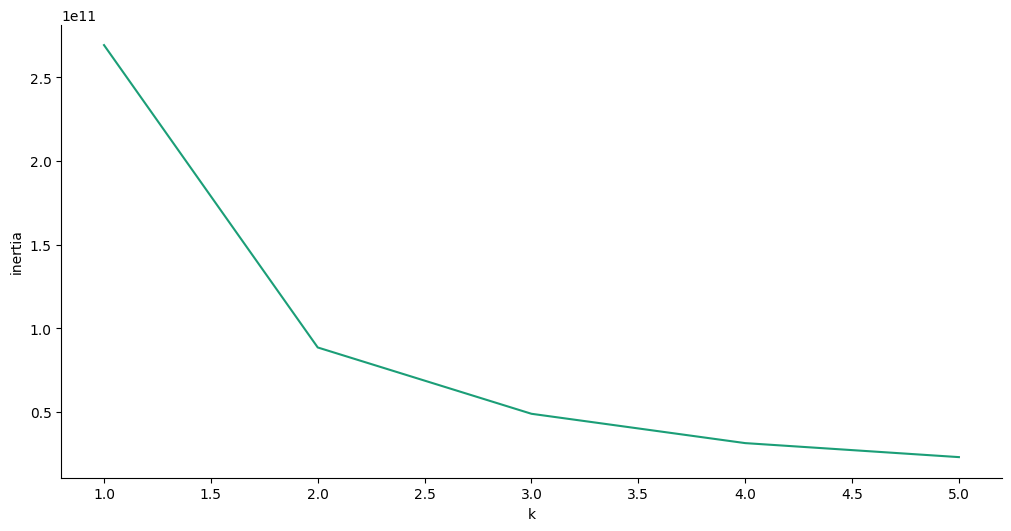

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['inertia']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('inertia')

In [29]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)


:Curve   [k]   (inertia)

In [30]:
# Define the model with the lower value of k clusters
# Use a random_state of 1 to generate the model
model = KMeans(n_clusters=4, random_state=1)

# Fit the model
model.fit(store_sales_df)

# Make predictions
k_lower = model.predict(store_sales_df)

# Create a copy of the DataFrame
store_sales_cluster_df = store_sales_df.copy()

# Add a class column with the labels to the spread_df_predictions DataFrame
store_sales_cluster_df['cluster_number'] = k_lower

#Print prediction
store_sales_cluster_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer,cluster_number
0,1,1659,1961,530,66490,14931,4.453151,125.452830,0
1,2,1461,1752,210,39820,13149,3.028367,189.619048,3
2,3,1340,1609,720,54010,12060,4.478441,75.013889,2
3,4,1451,1748,620,53730,13059,4.114404,86.661290,2
4,5,1770,2111,450,46620,15930,2.926554,103.600000,2


In [31]:
#Start Spark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
# Create a SparkSession object
spark = SparkSession.builder.getOrCreate()
# Create a DataFrame from the existing store_sales_cluster_df variable
store_sales_cluster_df = spark.createDataFrame(store_sales_cluster_df)
#create temp table to use spark.sql to understand cluster
store_sales_cluster_df.createOrReplaceTempView("cluster")
#group by cluster and look at average sales, sq. ft, and sales per sq. ft
store_sales_cluster_df.groupBy("cluster_number").agg(avg("Store_Sales"), avg("Sq_Ft"), avg("Sales_Per_Sq_Ft"), avg("Items_Available"), avg("Daily_Customer_Count"), avg("sales_per_customer")).show()

+--------------+-----------------+------------------+--------------------+--------------------+-------------------------+-----------------------+
|cluster_number| avg(Store_Sales)|        avg(Sq_Ft)|avg(Sales_Per_Sq_Ft)|avg(Items_Available)|avg(Daily_Customer_Count)|avg(sales_per_customer)|
+--------------+-----------------+------------------+--------------------+--------------------+-------------------------+-----------------------+
|             0|67154.18604651163|13492.186046511628|   5.114403095059547|   1798.562015503876|        780.9302325581396|     103.43709101469265|
|             1|84296.14942528735| 13721.48275862069|  6.3586799107986565|  1829.6436781609195|        794.0229885057471|     126.49744127508733|
|             3|36290.54347826087|12944.152173913044|    2.88759252218847|  1724.8641304347825|        777.8804347826087|      54.43010570474268|
|             2|51814.28571428572|13314.632142857143|   4.011114506891602|  1774.7928571428572|        792.1428571428571|   

In [32]:
store_sales_df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804,13368.686384,4.553968,94.043175
std,258.797218,250.237011,299.872053,265.389281,17190.741895,2252.133099,1.522267,162.819099
min,1.000000,775.000000,932.000000,10.000000,14920.000000,6975.000000,1.231475,15.070707
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000,11850.750000,3.451944,55.875573
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000,13293.000000,4.420069,75.409239
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000,14881.500000,5.414897,102.853319
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000,20061.000000,10.701001,4548.000000


Feature Engineering to Optimize models

In [107]:
# copy DF
store_sales_copy_df = store_sales_df.copy()
#Remove stores with less than 100 daily customerss
store_sales_copy_df = store_sales_copy_df[store_sales_copy_df['Daily_Customer_Count'] >= 250]
#Add Customers/Items
store_sales_copy_df['customer_per_item'] = store_sales_copy_df['Daily_Customer_Count'] /store_sales_copy_df['Items_Available']
#Add Items/sq. ft
store_sales_copy_df['items_per_sq_ft'] = store_sales_copy_df['Items_Available']/store_sales_copy_df['sq_ft']
#Add Customers/sq. ft
store_sales_copy_df['customer_per_sq_ft'] = store_sales_copy_df['Daily_Customer_Count'] /store_sales_copy_df['sq_ft']
store_sales_copy_df.describe()


,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer,customer_per_item,items_per_sq_ft,customer_per_sq_ft
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,448.363224,1486.120318,1782.869467,796.958002,59350.544835,13375.082860,4.551938,83.940490,0.462135,0.133308,0.061612
std,257.911921,251.652577,301.555189,254.621929,17189.024218,2264.873195,1.518632,41.961345,0.175467,0.001043,0.023421
min,1.000000,775.000000,932.000000,280.000000,14920.000000,6975.000000,1.231475,15.070707,0.126638,0.130399,0.016765
25%,226.000000,1316.000000,1574.000000,610.000000,46580.000000,11844.000000,3.454382,55.735294,0.338303,0.132568,0.044862
50%,448.000000,1480.000000,1774.000000,790.000000,58600.000000,13320.000000,4.422775,74.823529,0.450396,0.133301,0.059884
75%,670.000000,1655.000000,1988.000000,970.000000,71830.000000,14895.000000,5.411093,101.015385,0.566319,0.134018,0.075457
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000,20061.000000,10.701001,277.275862,1.419472,0.136481,0.188611


Evaluate Data distribution

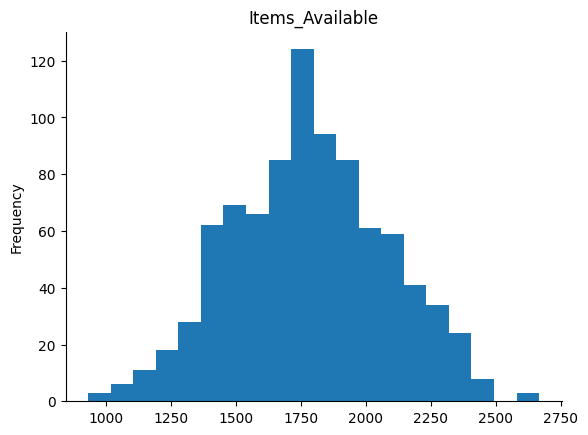

In [143]:
#distribution of items avaliable
store_sales_copy_df['Items_Available'].plot(kind='hist', bins=20, title='Items_Available')
plt.gca().spines[['top', 'right',]].set_visible(False)


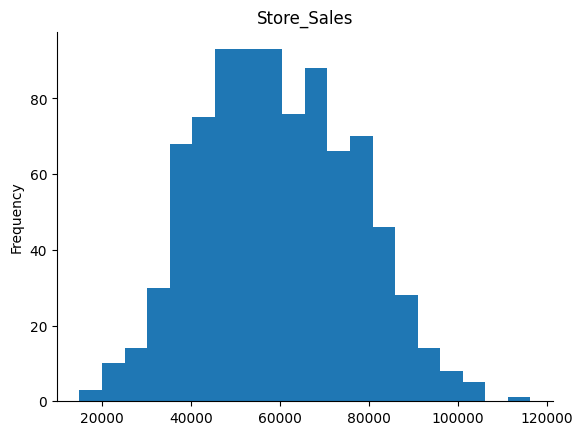

In [144]:
#distribution of store sales
store_sales_copy_df['Store_Sales'].plot(kind='hist', bins=20, title='Store_Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)


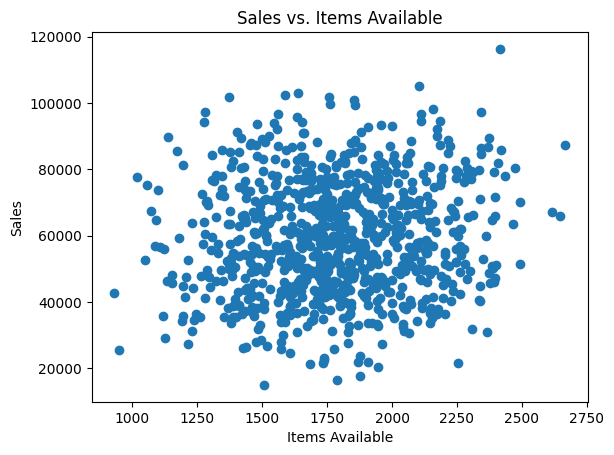

In [147]:
# Scatter Plot with items and store sales to see if there is a linear correlation
plt.scatter(store_sales_copy_df['Items_Available'], store_sales_copy_df['Store_Sales'])

# Set the title and axis labels
plt.title('Sales vs. Items Available')
plt.xlabel('Items Available')
plt.ylabel('Sales')

# Show the plot
plt.show()


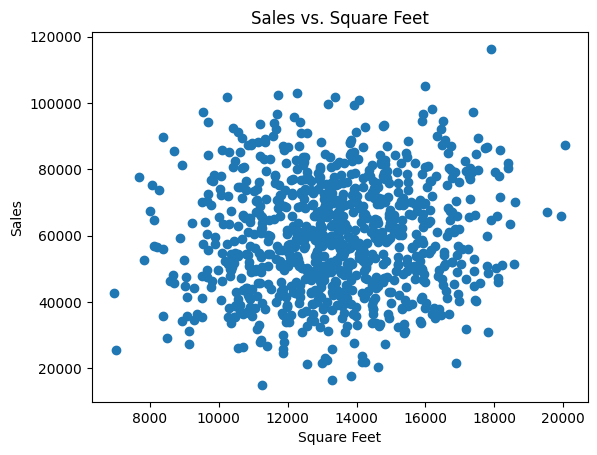

In [148]:
# Scatter Plot with sq. ft and sales to see if there is a linear correlation
plt.scatter(store_sales_df['sq_ft'], store_sales_df['Store_Sales'])

# Set the title and axis labels
plt.title('Sales vs. Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Sales')

# Show the plot
plt.show()


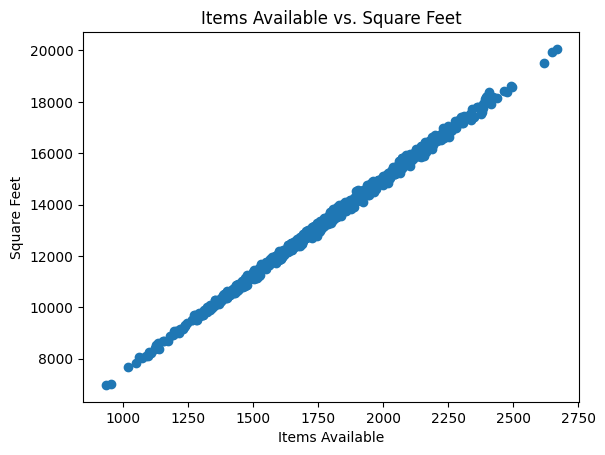

In [149]:
# Scatter Plot with items and sq. ft to see if there is a linear correlation
plt.scatter(store_sales_copy_df['Items_Available'], store_sales_copy_df['sq_ft'])

# Set the title and axis labels
plt.title('Items Available vs. Square Feet')
plt.xlabel('Items Available')
plt.ylabel('Square Feet')

# Show the plot
plt.show()


In [164]:
# Create correlations df

Correlation_df = store_sales_df[['sq_ft', 'Items_Available', 'Daily_Customer_Count', 'Store_Sales']]


In [158]:
#import seaboarn as sns

!pip install seaborn
import seaborn as sns


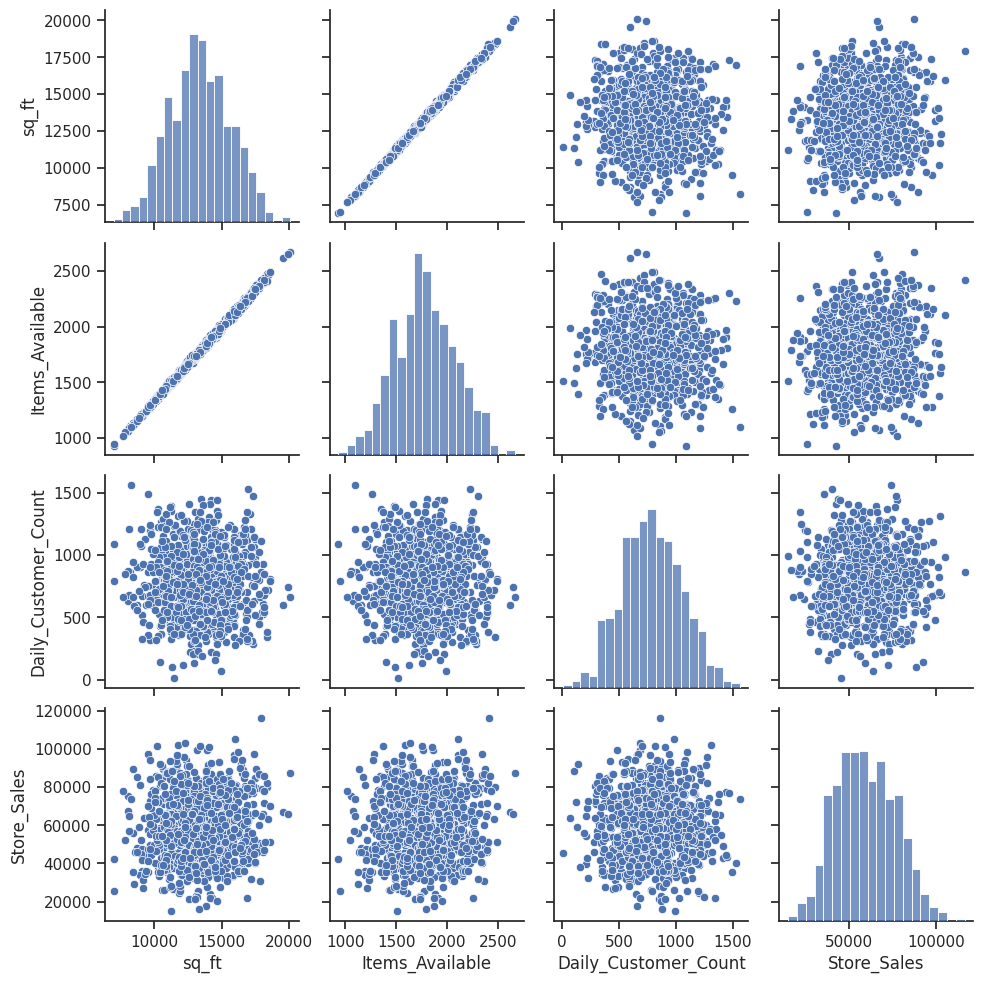

In [165]:
sns.set_theme(style="ticks",palette='deep')
sns.pairplot(Correlation_df)

Linear Regression Model


In [154]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
# Extract features (X) and target variable (y)
X = store_sales_copy_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count','customer_per_item','items_per_sq_ft','customer_per_sq_ft']]
y = store_sales_copy_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [155]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

Training Score: 0.014683938226917048
Mean Squared Error: 304705256.0020637
RMSE: 17455.80866078864
R2 score: -0.0031892937150437284


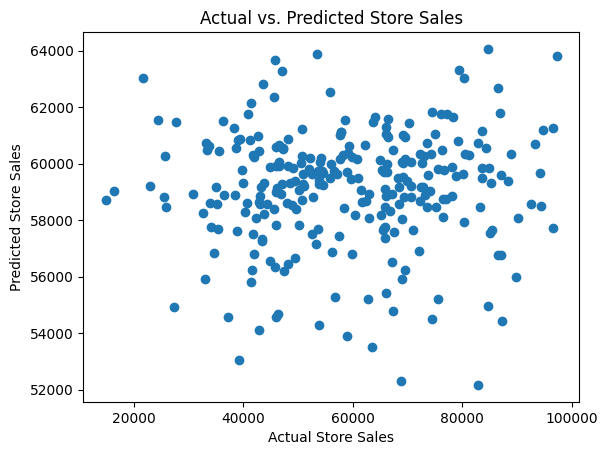

In [156]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
#Training score
print(f"Training Score: {model.score(X_train_scaled, y_train)}")
# MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
print("RMSE:", rmse)
# R2
r2 = metrics.r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()

In [153]:
# Feature Importance
feature_importance = model.coef_
print('Feature Importance:', feature_importance)

Feature Importance: [-4182.14017677  5728.15801236]


Random Forest


In [131]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
# Extract features (X) and target variable (y)
X = store_sales_copy_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count','customer_per_item','items_per_sq_ft','customer_per_sq_ft']]
y = store_sales_copy_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [133]:
from sklearn.ensemble import RandomForestRegressor
# Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model Evaluation
y_pred = rf_model.predict(X_test)
# Evaluate the model using metrics like Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Feature Importance
feature_importance = rf_model.feature_importances_
print('Feature Importance:', feature_importance)

Mean Squared Error: 351855710.7271698
R-squared: -0.15842400149344193
Feature Importance: [0.16037731 0.15214106 0.17232067 0.12375626 0.27250723 0.11889746]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Training Score: 0.014683938226917048
Mean Squared Error: 363058547.36403775
RMSE: 17455.80866078864
R2 score: -0.19530740127722646


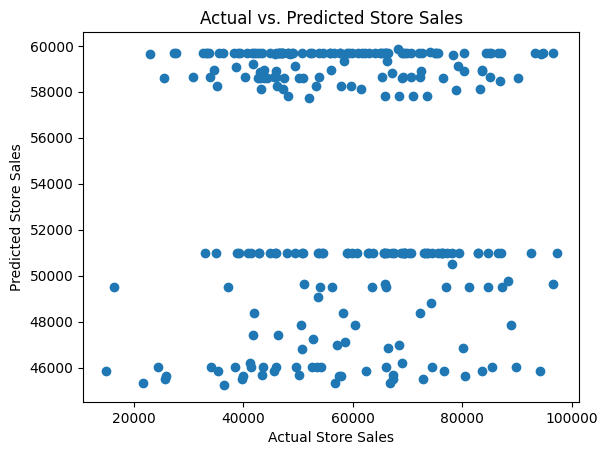

In [141]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)
#Training score
print(f"Training Score: {model.score(X_train_scaled, y_train)}")
# MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
print("RMSE:", rmse)
# R2
r2 = metrics.r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()

XGBoost Model

In [111]:
# Models
from xgboost.spark import SparkXGBRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [112]:
from sklearn.model_selection import train_test_split
# Extract features (X) and target variable (y)
X = store_sales_copy_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count','customer_per_item','items_per_sq_ft','customer_per_sq_ft']]
y = store_sales_copy_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [113]:
#xgboost model
xgbr = XGBRegressor(random_state = 116)
xgbr.fit(X_train_scaled, y_train)
xgbr_pred =xgbr.predict(X_test_scaled)

In [114]:
import numpy as np
mse = mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_pred))
score = xgbr.score(X_train, y_train)
r2 =r2_score(y_test,  xgbr_pred)

Training score:  -0.5014266161303904
MSE: 416711504.23
RMSE: 20413.51
R_score : -0.37


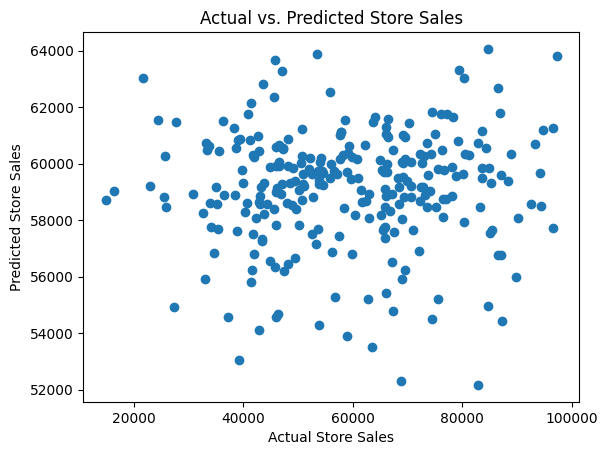

In [115]:
print("Training score: ", score)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("R_score : %.2f"%(r2))
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()

KNN Model

In [120]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
# Extract features (X) and target variable (y)
X = store_sales_copy_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count']]
y = store_sales_copy_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [121]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/100
20/20 [==============================] - 1s 16ms/step - loss: 3823005952.0000 - val_loss: 3804920320.0000
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 3822899456.0000 - val_loss: 3804803072.0000
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 3822745600.0000 - val_loss: 3804609024.0000
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 3822487552.0000 - val_loss: 3804283392.0000
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 3822060032.0000 - val_loss: 3803767808.0000
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 3821402880.0000 - val_loss: 3802987776.0000
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 3820445440.0000 - val_loss: 3801894656.0000
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 3819112448.0000 - val_loss: 3800409856.0000
Epoch 9/100
20/20 [==============================] - 0s 4ms/ste

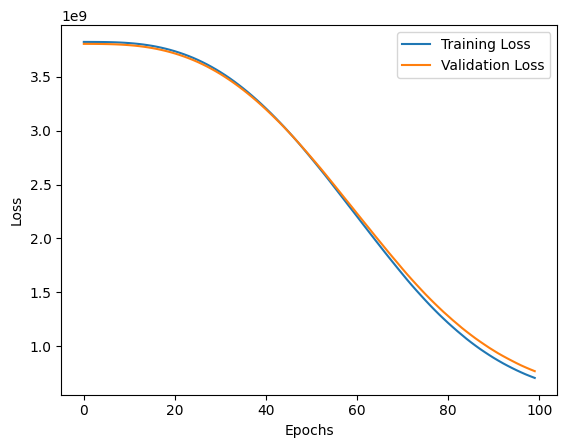

In [122]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 0s 3ms/step
MSE: 768008039.2843163
9/9 [==============================] - 0s 2ms/step
RMSE: 27712.95796706509
R2 score: -1.528533483819822


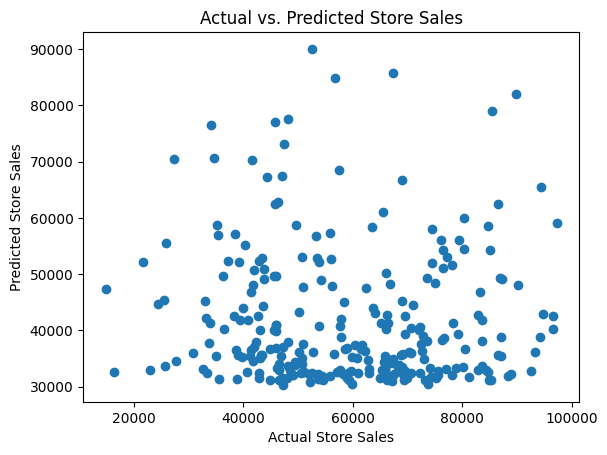

In [123]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
#MSE
mse = mean_squared_error(y_test, model.predict(X_test_scaled))
print("MSE:", mse)
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
print("RMSE:", rmse)
# R2
r2 = metrics.r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()